# Imports

Need to have jate.py in your folder

In [47]:
%run jate.py #will import everything

# Next chapter

## memory clear (uses regex, so be careful)

In [49]:
%reset_selective -f var1, var2  # replace var1, var2 with your defined ones

## Building parts

### Building the things to be calculated only once

In [51]:
def maker(omega_1, H_0, H_1, T_s, Lin, d=2, gamma=0.1):
    r"""maker
    Makes all the things that remain constant throught the program, but are 
    repeatedly used.
    

    Parameters
    ----------
    omega_1 : float
              frequency corresponding to half of the difference between 
              energy levels of the qubit
              
    H_0     : Qobj
              Bare Hamiltonian 
              
    H_1     : Qobj
              Interaction Hamiltonian 
              
    T_s     : Qobj
              Unitary to be implemented in the Hilbert space
    
    Lin     : Qobj
              Linbladian operators

    d       : int
              Dimension of the matrix. Defaults to 2
    
    gamma   : float
              Damping constantof the Linbladian

    
    Returns
    -------
    
    ih0     : Qobj
              $I\otimes H_{0}$
              
    ih1     : Qobj
              $I\otimes H_{1}$

    h0ci    : Qobj
              $H_{0}^{*}\otimes I $

    h1ci    : Qobj
              $H_{1}^{*}\otimes I $

    T       : Qobj
              Target unitary transformed to the Liouville space

    linbladian : Qobj
                 The full lindbladian term as it appears on transformation to 
                 the Liouville space.
        
    """
    I = identity(d)
    L_I = tensor(I, I)
    ih0 = tensor(I, H_0) 
    ih1 = tensor(I, H_1) 
    h0ci = tensor(H_0.conj(), I) 
    h1ci = tensor(H_1.conj(), I)
    x_k = ih1 - h1ci
    term1 = tensor(Lin.trans(), Lin)
    term2 = tensor(I, ((Lin.dag())*(Lin)))
    term3 = tensor(((Lin.trans())*(Lin.conj())), I)
    lindbladian = 1j*(gamma)*(term1 - 0.5*(term2 + term3))
    T = tensor(T_s.trans(), T_s) # Transforming $T_{s}$ to liouville space
    
    
    return ih0, ih1, h0ci, h1ci, x_k, lindbladian, T, L_I

In [53]:
omega_1 = 0.5
H_0 = omega_1*sigmaz() 
H_1 = sigmay()
T_s = sigmax() 
Lin = sigmaz()
ih0, ih1, h0ci, h1ci, x_k, lindbladian, T, L_I  = maker(omega_1,
                                                  H_0, H_1, T_s, 
                                                  Lin, d=2, gamma=0.1)

In [55]:
L_I

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

### Building $A(t)$

In [57]:
def A(xi):
    r"""making $A(t)$"""
    A = ih0 - h0ci + xi*(ih1 - h1ci) + lindbladian
    return A

In [59]:
A(0.5)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.+0.j   0.-0.5j  0.-0.5j  0.+0.j ]
 [ 0.+0.5j -1.-0.2j  0.+0.j   0.-0.5j]
 [ 0.+0.5j  0.+0.j   1.-0.2j  0.-0.5j]
 [ 0.+0.j   0.+0.5j  0.+0.5j  0.+0.j ]]

### Building $L(t)$ and the Identity in the Liouville space

In [61]:
def L(xi, dt):
    r"""Making $L(t) from $A(t)$"""
    L = (-1j*A(xi)*dt).expm()
    return L

In [63]:
L(0.5, 0.001)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 9.99999750e-01+0.00000000e+00j -4.99949837e-04-2.49966628e-07j
  -4.99949837e-04+2.49966628e-07j  2.49983293e-07+0.00000000e+00j]
 [ 4.99949837e-04+2.49966628e-07j  9.99799270e-01+9.99799687e-04j
  -2.49966628e-07+0.00000000e+00j -4.99949837e-04-2.49966628e-07j]
 [ 4.99949837e-04-2.49966628e-07j -2.49966628e-07+0.00000000e+00j
   9.99799270e-01-9.99799687e-04j -4.99949837e-04+2.49966628e-07j]
 [ 2.49983293e-07+0.00000000e+00j  4.99949837e-04+2.49966628e-07j
   4.99949837e-04-2.49966628e-07j  9.99999750e-01+0.00000000e+00j]]

## Major functions

### Major functions 1

In [64]:
# building the function to optimize (optimizee)
def L_vec(xi_vec, dt):
    r"""Building the vector of differential $L(t)$"""
    L_vec = [L(xi, dt) for xi in xi_vec] 
    return L_vec

In [65]:
def fidelity_calc(A, B):
    r"""Making a generalised fidelity function"""
    first_part = (A - B).dag()
    second_part = (A - B)
    f_int = (first_part* second_part)
    f = f_int.tr()
    return f

In [66]:
def L_full_maker(xi_vec, dt):
    r"""Building the $L(t)$ for the total time $t$"""
    xi_vec_size = xi_vec.size # finding the size of xi
    L_full = L_I # Identity for the for loop of L
    L_v = L_vec(xi_vec, dt) # calling L_vec
    for i in range(xi_vec_size): # generating L_full
        L_full = L_full*L_v[xi_vec_size - 1 - i]
    return L_full

In [67]:
def F(xi_vec, dt):
    r"""Using the fidelity metric to find out the closeness between $T$
    and $L(t)$"""
    L_full = L_full_maker(xi_vec, dt)
    F = real(-fidelity_calc(T, L_full))   
    return F

### Testing major functions 1

In [68]:
fidelity_calc(sigmax(), sigmay())

4.0

In [69]:
fidelity_calc(sigmay(), sigmay())

0.0

In [70]:
xi_vec_test = array([1.0, 2.0])
xi_vec_test

array([1., 2.])

In [71]:
xi_vec_test.size

2

In [72]:
w_vec = [xi**2 for xi in xi_vec_test]
w_vec

[1.0, 4.0]

In [73]:
# F(xi_vec, dt)
F(xi_vec_test, 0.001)

-7.998400634493138

In [74]:
L_v = L_vec(xi_vec_test, 0.001)

In [75]:
L_v

[Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
 Qobj data =
 [[ 9.99999000e-01+0.00000000e+00j -9.99899173e-04-4.99933130e-07j
   -9.99899173e-04+4.99933130e-07j  9.99932920e-07+0.00000000e+00j]
  [ 9.99899173e-04+4.99933130e-07j  9.99798520e-01+9.99799187e-04j
   -9.99866260e-07+0.00000000e+00j -9.99899173e-04-4.99933130e-07j]
  [ 9.99899173e-04-4.99933130e-07j -9.99866260e-07+0.00000000e+00j
    9.99798520e-01-9.99799187e-04j -9.99899173e-04+4.99933130e-07j]
  [ 9.99932920e-07+0.00000000e+00j  9.99899173e-04+4.99933130e-07j
    9.99899173e-04-4.99933130e-07j  9.99999000e-01+0.00000000e+00j]],
 Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
 Qobj data =
 [[ 9.99996000e-01+0.00000000e+00j -1.99979435e-03-9.99865260e-07j
   -1.99979435e-03+9.99865260e-07j  3.99972768e-06+0.00000000e+00j]
  [ 1.99979435e-03+9.99865260e-07j  9.99795521e-01+9.99797187e-04j
   -3.99946104e-06+0.00000000e+00j -1.99979435e-03-9.99865

### Major Functions 2

In [76]:
def L_comma_k_maker(xi_vec, k, dt):
    r"""Making of the derivative of full $L(t)$ at time $t_{k}$"""
    N = xi_vec.size 
    # Determining the size of xi, and thus the time_steps indirectly.
    L_v = L_vec(xi_vec, dt)# Making of the full $L(t)$
    inner_part = L_I # Beginner for the for loop
    for i in range(N):
        if i == ( N - 1 - k ):
            # The step at which $X_{k}(t)$ has to be inserted 
            inner_part = inner_part*x_k*L_v[k - 1]
        else:
            # Usual multiplications of $L_{k}$
            inner_part = inner_part*L_v[N - 1 - i]
    l_comma_k = inner_part
    return l_comma_k
    

In [77]:
# L_comma_k_maker(xi_vec, k, dt)
L_comma_k_maker(xi_vec_test, 2, 0.001)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 9.99991001e-01+0.00000000e+00j -2.99927960e-03-3.49898670e-06j
  -2.99927960e-03+3.49898670e-06j  8.99883703e-06+0.00000000e+00j]
 [ 2.99948056e-03+2.49939255e-06j  9.99589083e-01+1.99918650e-03j
  -8.99750347e-06+2.99899242e-09j -2.99948056e-03-2.49939255e-06j]
 [ 2.99948056e-03-2.49939255e-06j -8.99750347e-06-2.99899242e-09j
   9.99589083e-01-1.99918650e-03j -2.99948056e-03+2.49939255e-06j]
 [ 8.99883703e-06+0.00000000e+00j  2.99927960e-03+3.49898670e-06j
   2.99927960e-03-3.49898670e-06j  9.99991001e-01+0.00000000e+00j]]

In [78]:
def updater(xi_vec, dt, epsilon):
    r"""Implementing the GRAPE update step"""
    xi_vec_size = xi_vec.size # finding the size of xi
    L_full = L_full_maker(xi_vec, dt)
    di = []
    for k in range(xi_vec_size):
        # Building the thing to be added to the old function
        L_comma_k = L_comma_k_maker(xi_vec, k, dt)
        differentiated = T - L_comma_k
        plain = T - L_full
        c = -differentiated.dag()*plain
        d = -plain.dag()*differentiated
        inside = c.tr() + d.tr()
        di.append(epsilon*inside)

    diff = array(di)
    xi_new_vec = xi_vec + diff
    return diff, xi_new_vec
    

In [79]:
#  updater(xi_vec, dt, epsilon)
updater(xi_vec_test, 0.001, 0.001)

(array([-0.008+0.j, -0.008+0.j]), array([0.992+0.j, 1.992+0.j]))

In [80]:
import time

In [81]:
total_time_evo = 2*pi # total time allowed for evolution

In [82]:
times = linspace(0, total_time_evo, 500) 

In [83]:
# vector of times at which discretization 
# is carried out

In [84]:
U = T_s
U

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 1.]
 [1. 0.]]

In [85]:
R = 500

In [86]:
H_ops = [H_1]
H_ops

[Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[0.+0.j 0.-1.j]
  [0.+1.j 0.+0.j]]]

In [87]:
H_labels = [r'$g_{no diss}$']
H_labels

['$g_{no diss}$']

In [88]:
H0 = H_0
H0

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.5  0. ]
 [ 0.  -0.5]]

In [89]:
c_ops = []

In [90]:
from qutip.control.grape import plot_grape_control_fields, _overlap 
from qutip.control.grape import grape_unitary_adaptive, cy_grape_unitary

In [91]:
from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar

In [92]:
u0 = array([rand(len(times)) * 2 * pi * 0.05 for _ in range(len(H_ops))])

In [93]:
from numpy import convolve
u0 = [convolve(ones(10)/10, u0[idx,:], mode='same') for idx in range(len(H_ops))]

In [94]:
u_limits = None #[0, 1 * 2 * pi]
alpha = None

In [95]:
result = cy_grape_unitary(U, H0, H_ops, R, times, u_start=u0, u_limits=u_limits,
                          eps=2*np.pi*1, alpha=alpha, phase_sensitive=False,
                          progress_bar=TextProgressBar())

10.0%. Run time:  33.00s. Est. time left: 00:00:04:57
20.0%. Run time:  65.56s. Est. time left: 00:00:04:22
30.0%. Run time:  98.20s. Est. time left: 00:00:03:49
40.0%. Run time: 130.76s. Est. time left: 00:00:03:16
50.0%. Run time: 163.29s. Est. time left: 00:00:02:43
60.0%. Run time: 196.05s. Est. time left: 00:00:02:10
70.0%. Run time: 228.23s. Est. time left: 00:00:01:37
80.0%. Run time: 260.41s. Est. time left: 00:00:01:05
90.0%. Run time: 292.53s. Est. time left: 00:00:00:32
Total run time: 324.17s


#### Plot of optimized control field without dissipation

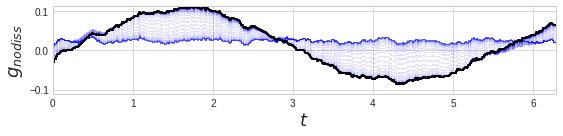

In [96]:
plot_grape_control_fields(times,
                          result.u / (2 * np.pi), H_labels, uniform_axes=True);

In [97]:
U

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 1.]
 [1. 0.]]

In [98]:
result.U_f

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 4.19464268e-16+3.62557206e-16j  1.51133447e-15+1.00000000e+00j]
 [-1.85838549e-15+1.00000000e+00j -5.69036734e-16-3.86843335e-16j]]

In [99]:
result.U_f/result.U_f[0,0]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 1.00000000e+00+0.00000000e+00j  1.17943905e+15+1.36456408e+15j]
 [ 1.17943905e+15+1.36456408e+15j -1.23274522e+00+1.43271629e-01j]]

(<Figure size 432x288 with 2 Axes>,
 <mpl_toolkits.mplot3d.axes3d.Axes3D at 0x7fa12c63a518>)

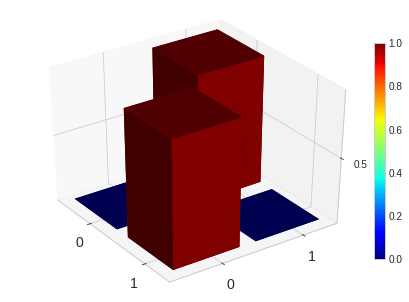

In [100]:
matrix_histogram(U)

(<Figure size 432x288 with 2 Axes>,
 <mpl_toolkits.mplot3d.axes3d.Axes3D at 0x7fa12c5ccd68>)

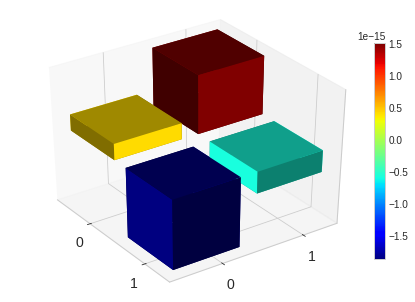

In [101]:
matrix_histogram(result.U_f)

(<Figure size 432x288 with 2 Axes>,
 <mpl_toolkits.mplot3d.axes3d.Axes3D at 0x7fa12c56dcf8>)

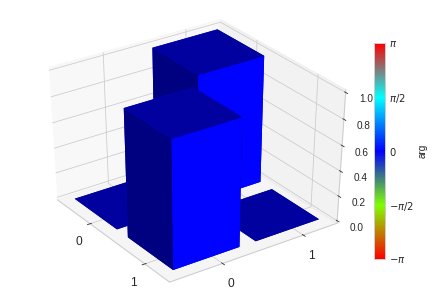

In [102]:
matrix_histogram_complex(U)

(<Figure size 432x288 with 2 Axes>,
 <mpl_toolkits.mplot3d.axes3d.Axes3D at 0x7fa12c4a9d30>)

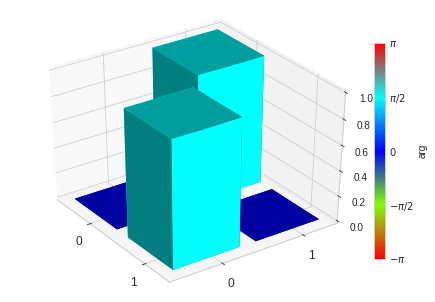

In [103]:
matrix_histogram_complex(result.U_f)

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa12c678d68>)

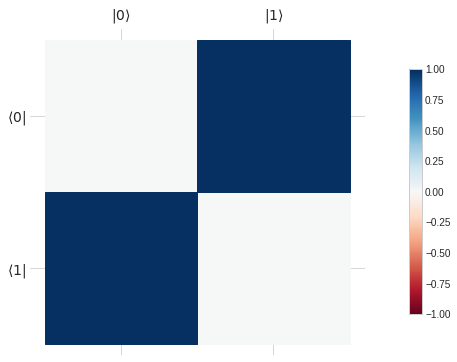

In [104]:
hinton(U)

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa12c69c5f8>)

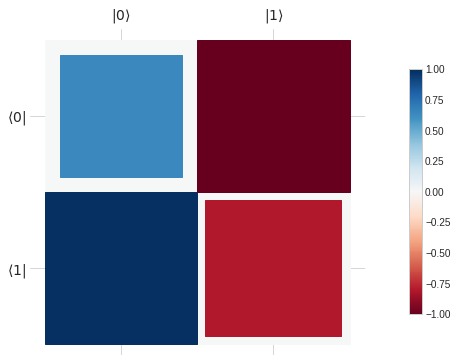

In [105]:
hinton(result.U_f)

In [106]:
times[-1]

6.283185307179586

In [107]:
total_time_evo

6.283185307179586

In [108]:
total_time

NameError: name 'total_time' is not defined

In [109]:
len(times)

500

In [110]:
def terminator(max_iter, time_steps=len(times), total_time= total_time_evo,
               epsilon= 2*pi*1):
    r"""Brief description of the function"""
    
    xi_initial = result.u[-1, 0, : ] 
    #1000*random_sample((time_steps,))
    dt = (2*pi)/500  #total_time/time_steps
    xi_diff, xi_new_vec = updater(xi_initial, dt, epsilon)
    
    for i in range(max_iter):
        if amax(xi_diff) < epsilon**2 :
            
            xi_final = xi_new_vec
            break
        else :
            xi_diff, xi_new_vec = updater(xi_new_vec, dt, epsilon)
            print(i)
            print(amax(xi_diff))
            
        
    xi_final = xi_new_vec    
    return xi_final

## sub topic 3

### try

In [111]:
xi_opt = terminator(10)

In [112]:
time_steps=len(times)
total_time= total_time_evo
epsilon= 2*pi*1

In [113]:
dt = (2*pi)/500
F(xi_opt, dt)

-4.223783391928767

In [114]:
L_full_maker(xi_opt, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.34531607+0.00000000e+00j  0.21664327+7.15222921e-03j
   0.21664327-7.15222921e-03j  0.65468393+0.00000000e+00j]
 [-0.21661836-7.19825486e-03j -0.01367562+1.04040912e-02j
  -0.29814809+8.45118844e-05j  0.21661836+7.19825486e-03j]
 [-0.21661836+7.19825486e-03j -0.29814809-8.45118844e-05j
  -0.01367562-1.04040912e-02j  0.21661836-7.19825486e-03j]
 [ 0.65468393+0.00000000e+00j -0.21664327-7.15222921e-03j
  -0.21664327+7.15222921e-03j  0.34531607+0.00000000e+00j]]

### try

In [115]:
xi_opt = terminator(1000)

In [116]:
time_steps=len(times)
total_time= total_time_evo
epsilon= 2*pi*1

In [117]:
dt = (2*pi)/500
F(xi_opt, dt)

-4.223783391928767

In [118]:
L_full_maker(xi_opt, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.34531607+0.00000000e+00j  0.21664327+7.15222921e-03j
   0.21664327-7.15222921e-03j  0.65468393+0.00000000e+00j]
 [-0.21661836-7.19825486e-03j -0.01367562+1.04040912e-02j
  -0.29814809+8.45118844e-05j  0.21661836+7.19825486e-03j]
 [-0.21661836+7.19825486e-03j -0.29814809-8.45118844e-05j
  -0.01367562-1.04040912e-02j  0.21661836-7.19825486e-03j]
 [ 0.65468393+0.00000000e+00j -0.21664327-7.15222921e-03j
  -0.21664327+7.15222921e-03j  0.34531607+0.00000000e+00j]]

### try

In [121]:
xi_opt = terminator(1000,time_steps=len(times), total_time= total_time_evo,
               epsilon= ((0.1*2*pi)/(times[-1])))

In [123]:
time_steps=len(times)
total_time= total_time_evo
epsilon = ((0.1*2*pi)/(times[-1]))

In [124]:
dt = (2*pi)/500
F(xi_opt, dt)

-2.239742398764373

In [125]:
L_full_maker(xi_opt, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.32265089+0.j          0.09132   -0.08833361j  0.09132   +0.08833361j
   0.67734911+0.j        ]
 [ 0.24445757+0.06094393j -0.05328591+0.007719j    0.17495538+0.26236373j
  -0.24445757-0.06094393j]
 [ 0.24445757-0.06094393j  0.17495538-0.26236373j -0.05328591-0.007719j
  -0.24445757+0.06094393j]
 [ 0.67734911+0.j         -0.09132   +0.08833361j -0.09132   -0.08833361j
   0.32265089+0.j        ]]

### try

In [126]:
xi_opt = terminator(10,time_steps=len(times), total_time= total_time_evo,
               epsilon= ((0.1*2*pi)/(times[-1])))

In [127]:
time_steps=len(times)
total_time= total_time_evo
epsilon = ((0.1*2*pi)/(times[-1]))

In [128]:
dt = (2*pi)/500
F(xi_opt, dt)

-2.239742398764373

In [129]:
L_full_maker(xi_opt, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.32265089+0.j          0.09132   -0.08833361j  0.09132   +0.08833361j
   0.67734911+0.j        ]
 [ 0.24445757+0.06094393j -0.05328591+0.007719j    0.17495538+0.26236373j
  -0.24445757-0.06094393j]
 [ 0.24445757-0.06094393j  0.17495538-0.26236373j -0.05328591-0.007719j
  -0.24445757+0.06094393j]
 [ 0.67734911+0.j         -0.09132   +0.08833361j -0.09132   -0.08833361j
   0.32265089+0.j        ]]

### try

In [130]:
xi_opt = terminator(1000,time_steps=len(times), total_time= total_time_evo,
               epsilon= ((0.1*2*pi)/(10**3)))

In [131]:
time_steps=len(times)
total_time= total_time_evo
epsilon = ((0.1*2*pi)/(times[-1]))

In [132]:
dt = (2*pi)/500
F(xi_opt, dt)

-0.9548953874356939

In [133]:
L_full_maker(xi_opt, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.22002491+0.j          0.03339471-0.02595677j  0.03339471+0.02595677j
   0.77997509+0.j        ]
 [-0.03813763+0.00505873j -0.06506713-0.04837801j  0.39394511+0.01452643j
   0.03813763-0.00505873j]
 [-0.03813763-0.00505873j  0.39394511-0.01452643j -0.06506713+0.04837801j
   0.03813763+0.00505873j]
 [ 0.77997509+0.j         -0.03339471+0.02595677j -0.03339471-0.02595677j
   0.22002491+0.j        ]]

### try

In [134]:
xi_opt = terminator(1000,time_steps=len(times), total_time= total_time_evo,
               epsilon= ((0.1*2*pi)/(10**4)))

In [135]:
dt = (2*pi)/500
F(xi_opt, dt)

-0.9547563688866646

In [136]:
L_full_maker(xi_opt, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.22001535+0.j          0.03474667-0.02672425j  0.03474667+0.02672425j
   0.77998465+0.j        ]
 [-0.03817028+0.00489227j -0.06428089-0.04846861j  0.39408493+0.01206342j
   0.03817028-0.00489227j]
 [-0.03817028-0.00489227j  0.39408493-0.01206342j -0.06428089+0.04846861j
   0.03817028+0.00489227j]
 [ 0.77998465+0.j         -0.03474667+0.02672425j -0.03474667-0.02672425j
   0.22001535+0.j        ]]

### try

In [137]:
xi_opt = terminator(10**4,time_steps=len(times), total_time= total_time_evo,
               epsilon= ((0.1*2*pi)/(10**3)))

In [138]:
dt = (2*pi)/500
F(xi_opt, dt)

-0.9548953874356939

In [139]:
L_full_maker(xi_opt, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.22002491+0.j          0.03339471-0.02595677j  0.03339471+0.02595677j
   0.77997509+0.j        ]
 [-0.03813763+0.00505873j -0.06506713-0.04837801j  0.39394511+0.01452643j
   0.03813763-0.00505873j]
 [-0.03813763-0.00505873j  0.39394511-0.01452643j -0.06506713+0.04837801j
   0.03813763+0.00505873j]
 [ 0.77997509+0.j         -0.03339471+0.02595677j -0.03339471-0.02595677j
   0.22002491+0.j        ]]

### try

In [140]:
xi_opt = terminator(10**4,time_steps=len(times), total_time= total_time_evo,
               epsilon= ((0.1*2*pi)/(10**4)))

In [141]:
dt = (2*pi)/500
F(xi_opt, dt)

-0.9547563688866646

In [142]:
L_full_maker(xi_opt, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.22001535+0.j          0.03474667-0.02672425j  0.03474667+0.02672425j
   0.77998465+0.j        ]
 [-0.03817028+0.00489227j -0.06428089-0.04846861j  0.39408493+0.01206342j
   0.03817028-0.00489227j]
 [-0.03817028-0.00489227j  0.39408493-0.01206342j -0.06428089+0.04846861j
   0.03817028+0.00489227j]
 [ 0.77998465+0.j         -0.03474667+0.02672425j -0.03474667-0.02672425j
   0.22001535+0.j        ]]

### try

In [143]:
xi_opt = terminator(10**4,time_steps=len(times), total_time= total_time_evo,
               epsilon= ((0.1*2*pi)/(10**10)))

In [144]:
dt = (2*pi)/500
F(xi_opt, dt)

-0.9547464377063413

In [145]:
L_full_maker(xi_opt, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.2200145 +0.j          0.03489843-0.02680916j  0.03489843+0.02680916j
   0.7799855 +0.j        ]
 [-0.03817266+0.00487285j -0.06419262-0.04847836j  0.39409941+0.0117909j
   0.03817266-0.00487285j]
 [-0.03817266-0.00487285j  0.39409941-0.0117909j  -0.06419262+0.04847836j
   0.03817266+0.00487285j]
 [ 0.7799855 +0.j         -0.03489843+0.02680916j -0.03489843-0.02680916j
   0.2200145 +0.j        ]]

### try

In [143]:
xi_opt = terminator(10**4,time_steps=10**3, total_time= total_time_evo,
               epsilon= ((0.1*2*pi)/(10**3)))

In [144]:
dt = (2*pi)/#(2*pi)/500
F(xi_opt, dt)

-0.9547464377063413

In [145]:
L_full_maker(xi_opt, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.2200145 +0.j          0.03489843-0.02680916j  0.03489843+0.02680916j
   0.7799855 +0.j        ]
 [-0.03817266+0.00487285j -0.06419262-0.04847836j  0.39409941+0.0117909j
   0.03817266-0.00487285j]
 [-0.03817266-0.00487285j  0.39409941-0.0117909j  -0.06419262+0.04847836j
   0.03817266+0.00487285j]
 [ 0.7799855 +0.j         -0.03489843+0.02680916j -0.03489843-0.02680916j
   0.2200145 +0.j        ]]

## Versions

In [119]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.3.1
Numpy,1.15.1
SciPy,1.1.0
matplotlib,2.2.3
Cython,0.28.5
Number of CPUs,4
BLAS Info,INTEL MKL
IPython,6.5.0
Python,"3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) [GCC 7.3.0]"
OS,posix [linux]


In [120]:
cnot()

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]